In [ ]:
import polars as ps

def read_data():
    # Replace with your actual data reading logic
    # For example, using pandas to read CSV files
    SOIgood = ps.read_csv('/content/SOI_good.csv')
    SOIbad = ps.read_csv('/content/SOI_bad.csv')
    return SOIgood, SOIbad

SOIgood, SOIbad = read_data()
SOIgood = SOIgood.to_numpy()
SOIbad = SOIbad.to_numpy()


In [ ]:
import matplotlib.pyplot as plt

def build_spectrogram(signal, fs=48000):
    plt.figure(figsize=(10, 6))
    Pxx, freqs, bins, im = plt.specgram(signal, NFFT=256, Fs=fs, noverlap=128, cmap='viridis')
    plt.colorbar(im).set_label('Intensity [dB]')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Signal Spectrogram')
    plt.show()

# Example usage
# build_spectrogram(your_signal_here)


In [ ]:
import numpy as np
from scipy.signal import welch, find_peaks
from scipy.fft import fft


def extract_features2(signal_segment, fs):
    # Compute the FFT
    # import ipdb; ipdb.set_trace()
    fft_vals = fft(signal_segment)
    fft_freq = np.fft.fftfreq(len(signal_segment), 1/fs)

    # # Find the peak frequency
    # peak_freq = fft_freq[np.argmax(np.abs(fft_vals))]

    # # Calculate the mean frequency
    # mean_freq = np.sum(np.abs(fft_vals) * np.abs(fft_freq)) / np.sum(np.abs(fft_vals))

    # peak_freq, mean_freq

    # Take only the positive half of the spectrum and frequencies
    positive_freqs = fft_freq[:len(fft_freq)//2]
    positive_fft_vals = np.abs(fft_vals)[:len(fft_vals)//2]

    # Find the peak frequency
    peak_freq = fft_freq[np.argmax(fft_vals)]
    rms = np.sqrt(np.mean(np.square(fft_vals)))

    # Calculate the mean frequency
    power_spectrum = fft_vals ** 2
    mean_freq = np.sum(power_spectrum * fft_freq) / np.sum(power_spectrum)


    return peak_freq, rms


In [ ]:
Fs = 48000
window_size = 1024
overlap = 128

num_windows_good = int(np.floor((len(SOIgood) - overlap) / (window_size - overlap)))
num_windows_bad = int(np.floor((len(SOIbad) - overlap) / (window_size - overlap)))
features_good = np.zeros((num_windows_good, 2))
features_bad = np.zeros((num_windows_bad, 2))

for i in range(num_windows_good):
    start_idx = i * (window_size - overlap)
    end_idx = start_idx + window_size
    peak_freq, mean_freq = extract_features2(SOIgood[start_idx:end_idx], Fs)
    features_good[i, :] = [peak_freq, mean_freq]

# Repeat for SOIbad
for i in range(num_windows_bad):
    start_idx = i * (window_size - overlap)
    end_idx = start_idx + window_size
    peak_freq, mean_freq = extract_features2(SOIbad[start_idx:end_idx], Fs)
    features_bad[i, :] = [peak_freq, mean_freq]

<ipython-input-10-87415a8c99c0>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  features_good[i, :] = [peak_freq, mean_freq]
<ipython-input-10-87415a8c99c0>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  features_bad[i, :] = [peak_freq, mean_freq]


In [ ]:
# Create labels for good and bad features
# Assuming label 0 for good and 1 for bad
labels_good = np.zeros(num_windows_good, dtype=int)  # All zeros, representing good
labels_bad = np.ones(num_windows_bad, dtype=int)  # All ones, representing bad

# Combine the features and labels
all_features = np.vstack((features_bad, features_good))
all_labels = np.concatenate((labels_bad, labels_good))


In [ ]:
# build_spectrogram(features_good[:, 1])

In [ ]:
# build_spectrogram(features_bad[:, 1])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(all_features)

# # Assuming normalized_features is your data and num_windows is already defined
# num_samples = normalized_features.shape[0]
# num_training = int(np.floor(0.8 * num_samples))
# num_testing = num_samples - num_training

# # Create random indices for splitting the data
# indices = np.random.permutation(num_samples)
# training_indices = indices[:num_training]
# testing_indices = indices[num_training:]

# # Split the data into training and testing sets
# training_data = normalized_features[training_indices, :]
# testing_data = normalized_features[testing_indices, :]

# # Generate labels based on the condition (true if bad, false if good)
# training_labels = training_indices > num_windows
# testing_labels = testing_indices > num_windows


In [ ]:
# Splitting Data
training_data, testing_data, training_labels, testing_labels = train_test_split(
    normalized_features, all_labels, test_size=0.3)


In [ ]:
from sklearn.cluster import KMeans
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters)
idx = kmeans.fit_predict(training_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


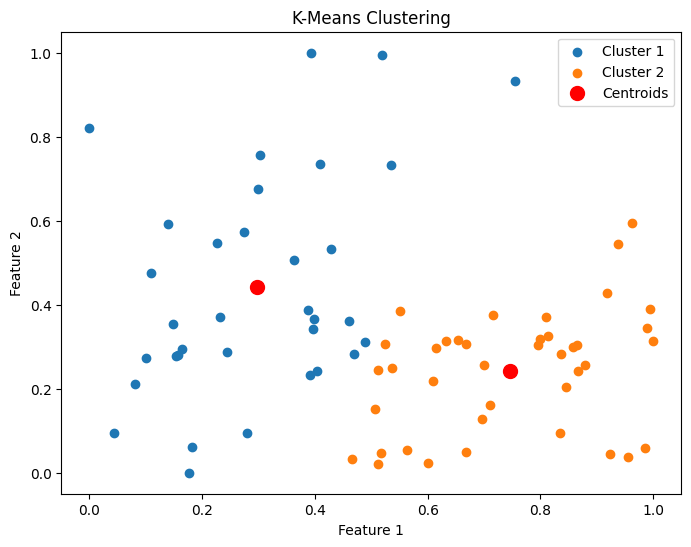

In [ ]:
clusters = kmeans.fit_predict(training_data)

# Plotting the clusters
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    plt.scatter(training_data[clusters == i, 0], training_data[clusters == i, 1], label=f'Cluster {i+1}')

# Plotting the centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='red', label='Centroids')

plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

predicted_labels = kmeans.fit_predict(testing_data)
conf_matrix = confusion_matrix(testing_labels, predicted_labels)
accuracy = accuracy_score(testing_labels, predicted_labels)
precision = precision_score(testing_labels, predicted_labels)
recall = recall_score(testing_labels, predicted_labels)
f1 = f1_score(testing_labels, predicted_labels)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 0.50
Precision: 0.33
Recall: 0.23
F1 Score: 0.27


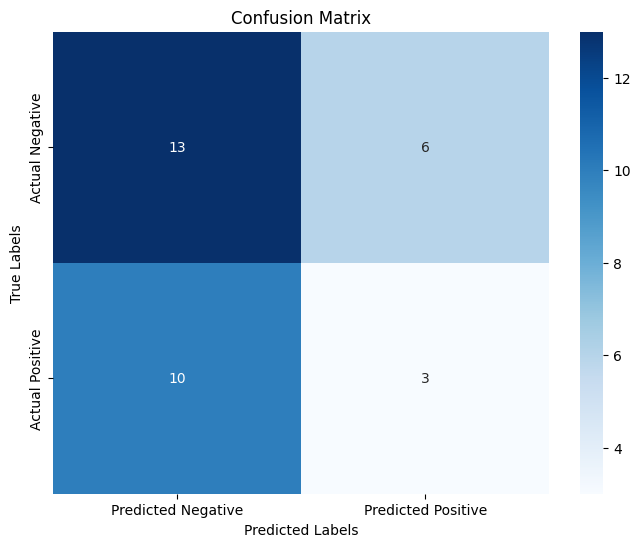

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming testing_labels and predicted_labels are already defined

# Calculate confusion matrix
conf_matrix = confusion_matrix(testing_labels, predicted_labels)

# Calculate metrics
accuracy = accuracy_score(testing_labels, predicted_labels)
precision = precision_score(testing_labels, predicted_labels)
recall = recall_score(testing_labels, predicted_labels)
f1 = f1_score(testing_labels, predicted_labels)

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Display confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10589 sha256=d7c5046956f55f7cbb3f98f0c7a2231878eb0ad42bff54cbb2162abfcaab4740
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
Successfully built minisom


In [ ]:
from minisom import MiniSom

# som = MiniSom(x=8, y=8, input_len=training_data.shape[1], sigma=1.0, learning_rate=0.5)
# som.train(training_data, num_iteration=100)
from minisom import MiniSom

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

from bokeh.colors import RGB
from bokeh.io import curdoc, show, output_notebook
from bokeh.transform import factor_mark, factor_cmap
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, output_file

NameError: ignored

In [ ]:
def classify(som, new_data, X_train, y_train):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    xx, yy = som.get_euclidean_coordinates()
    umatrix = som.distance_map()
    weights = som.get_weights()
    winmap = som.labels_map(X_train, y_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in new_data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)


    f = plt.figure(figsize=(10,10))
    ax = f.add_subplot(111)

    ax.set_aspect('equal')
    # Calculate the hit frequency
    # Calculate hits
    hits = np.zeros((8, 8))
    max_hits = 0
    for x in new_data:
        winner = som.winner(x)
        hits[winner] += 1
        if hits[winner] > max_hits:
          max_hits = hits[winner]

    for position, frequency in np.ndenumerate(hits):
        plt.text(position[1], position[0]-position[0]/10, str(int(frequency)), ha='center', va='center')

    norm = plt.Normalize(0, max_hits)
    # iteratively add hexagons
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            wy = yy[(i, j)] * np.sqrt(3) / 2
            hex = RegularPolygon((xx[(i, j)], wy),
                                numVertices=6,
                                radius=.95 / np.sqrt(3),
                                facecolor=cm.Reds(norm(hits[i, j])),
                                alpha=.7,
                                edgecolor='gray')
            ax.add_patch(hex)

    markers = ['o', '+']
    colors = ['C0', 'C1']
    for cnt, x in enumerate(training_data):
        # getting the winner
        w = som.winner(x)
        # place a marker on the winning position for the sample xx
        wx, wy = som.convert_map_to_euclidean(w)
        wy = wy * np.sqrt(3) / 2
        plt.plot(wx, wy,
                markers[training_labels[cnt]-1],
                markerfacecolor='None',
                markeredgecolor=colors[training_labels[cnt]-1],
                markersize=12,
                markeredgewidth=2)

    xrange = np.arange(weights.shape[0])
    yrange = np.arange(weights.shape[1])
    plt.xticks(xrange-.5, xrange)
    plt.yticks(yrange * np.sqrt(3) / 2, yrange)

    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues,
                                orientation='vertical', alpha=.4)
    cb1.ax.get_yaxis().labelpad = 16
    cb1.ax.set_ylabel('distance from neurons in the neighbourhood',
                      rotation=270, fontsize=16)
    plt.gcf().add_axes(ax_cb)

    legend_elements = [Line2D([0], [0], marker='o', color='C0', label='good',
                      markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                      Line2D([0], [0], marker='+', color='C1', label='bad',
                      markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)]
    ax.legend(handles=legend_elements, bbox_to_anchor=(0.1, 1.08), loc='upper left',
              borderaxespad=0., ncol=3, fontsize=14)

    plt.show()

    # f = plt.figure(figsize=(10, 10))
    # ax = f.add_subplot(111)
    # ax.set_aspect('equal')

    # # Calculate the hit frequency
    # # Calculate hits
    # hits = np.zeros((8, 8))
    # for x in new_data:
    #     winner = som.winner(x)
    #     hits[winner] += 1

    # # Create figure
    # f = plt.figure(figsize=(10, 10))
    # ax = f.add_subplot(111)
    # ax.set_aspect('equal')

    # # Plot hexagons with hit counts
    # for position, frequency in np.ndenumerate(hits):
    #     offset = 0.5 if position[0] % 2 == 0 else 0
    #     hex = RegularPolygon((position[1] + offset, position[0]), numVertices=6, radius=0.5, facecolor=plt.cm.Blues(frequency / np.max(hits)), edgecolor='gray')
    #     ax.add_patch(hex)
    #     plt.text(position[1] + offset, position[0], str(int(frequency)), ha='center', va='center')


    # # Set axis labels
    # xrange = np.arange(8)
    # yrange = np.arange(8)
    # plt.xticks(xrange, xrange)
    # plt.yticks(yrange * np.sqrt(3) / 2, yrange)

    # # Add color legend
    # legend_elements = [Line2D([0], [0], marker='o', color='C0', label='Label 1',
    #                           markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
    #                   Line2D([0], [0], marker='+', color='C1', label='Label 2',
    #                           markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)]
    # ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

    # plt.show()
    return result

In [ ]:
# from sklearn.metrics import classification_report

# som = MiniSom(8, 8, 2, sigma=1, learning_rate=0.5,
#               random_seed=10)
# som.pca_weights_init(training_data)
# som.train_random(training_data, 100, verbose=True)

# print(classification_report(testing_labels, classify(som, testing_data, training_data, training_labels)))

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 0.10299702563019283


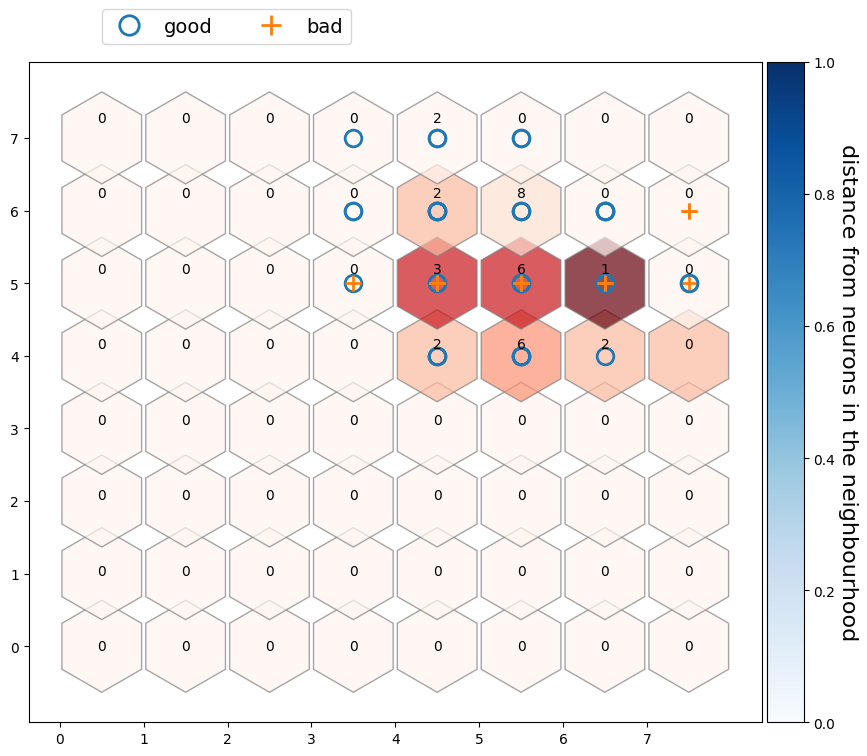

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.86      0.92        14

    accuracy                           0.94        32
   macro avg       0.95      0.93      0.94        32
weighted avg       0.94      0.94      0.94        32



In [ ]:
training_data, testing_data, training_labels, testing_labels = train_test_split(
    normalized_features, all_labels, test_size=0.3)


from sklearn.metrics import classification_report

som = MiniSom(8, 8, 2, sigma=1, learning_rate=0.1,
               neighborhood_function='triangle',
              random_seed=10)
som.pca_weights_init(training_data)
som.train_random(training_data, 100, verbose=True)

print(classification_report(testing_labels, classify(som, testing_data, training_data, training_labels)))

In [ ]:
# test_sizes = [0.3, 0.5, 0.7]
# learning_rates = [0.1, 0.5, 1, 2, 2.5]
# num_epochs = [100, 500, 1000]

# # Iterate over all combinations
# for test_size in test_sizes:
#     for lr in learning_rates:
#         for epoch in num_epochs:
#             # Initialize and train MiniSom
#             training_data, testing_data, training_labels, testing_labels = train_test_split(
#             normalized_features, all_labels, test_size=test_size)
#             som = MiniSom(8, 8, 2, sigma=1, learning_rate=lr,
#                           neighborhood_function='triangle', random_seed=10)
#             som.pca_weights_init(training_data)
#             som.train_random(training_data, epoch, verbose=True)

#             # Evaluate the model
#             predictions = classify(som, testing_data, training_data, training_labels)
#             report = classification_report(testing_labels, predictions)
#             print(f"Test Size: {test_size}, Learning Rate: {lr}, Epochs: {epoch}")
#             print(report)

In [ ]:
from minisom import MiniSom

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

from bokeh.colors import RGB
from bokeh.io import curdoc, show, output_notebook
from bokeh.transform import factor_mark, factor_cmap
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, output_file

# display matplotlib plots in notebook
%matplotlib inline

In [ ]:
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()

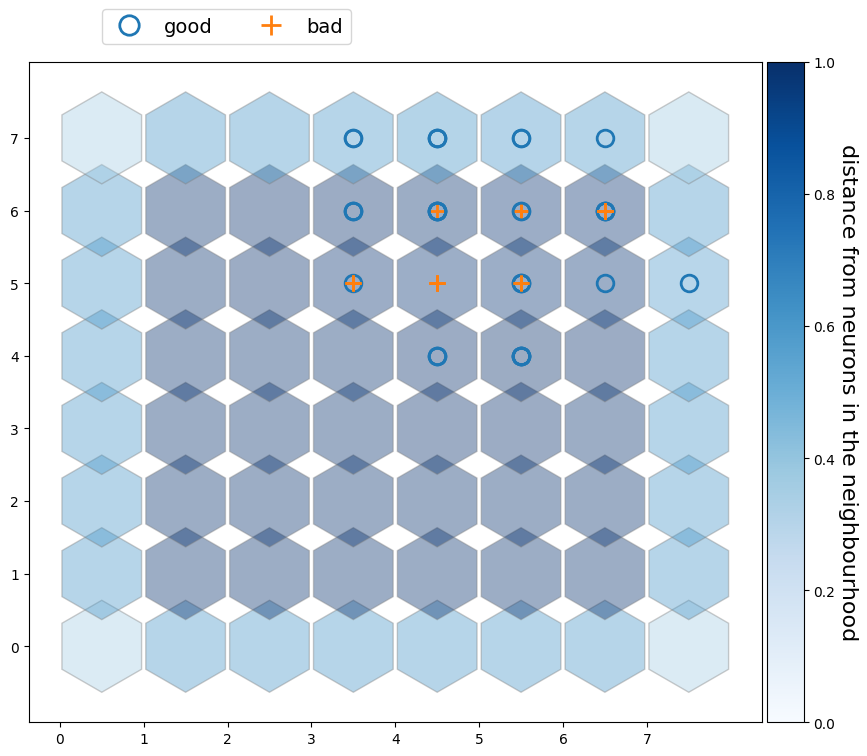

In [ ]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# iteratively add hexagons
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        hex = RegularPolygon((xx[(i, j)], wy),
                             numVertices=6,
                             radius=.95 / np.sqrt(3),
                             facecolor=cm.Blues(umatrix[i, j]),
                             alpha=.4,
                             edgecolor='gray')
        ax.add_patch(hex)

markers = ['o', '+']
colors = ['C0', 'C1']
for cnt, x in enumerate(training_data):
    # getting the winner
    w = som.winner(x)
    # place a marker on the winning position for the sample xx
    wx, wy = som.convert_map_to_euclidean(w)
    wy = wy * np.sqrt(3) / 2
    plt.plot(wx, wy,
             markers[training_labels[cnt]-1],
             markerfacecolor='None',
             markeredgecolor=colors[training_labels[cnt]-1],
             markersize=12,
             markeredgewidth=2)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues,
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('distance from neurons in the neighbourhood',
                  rotation=270, fontsize=16)
plt.gcf().add_axes(ax_cb)

legend_elements = [Line2D([0], [0], marker='o', color='C0', label='good',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='+', color='C1', label='bad',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.1, 1.08), loc='upper left',
          borderaxespad=0., ncol=3, fontsize=14)

plt.show()

In [ ]:
import pickle
import csv


labels_column = training_labels.reshape(-1, 1)
combined_data = np.concatenate([training_data, labels_column], axis=1)
df_subset = pd.DataFrame(combined_data, columns=['peak_freq', 'mean_freq', 'label'])
df_subset.to_csv('/content/som_best_100_acc_training_data.csv', index=False)

with open('/content/som_best_100_acc.p', 'wb') as outfile:
    pickle.dump(som, outfile)

labels_column2 = testing_labels.reshape(-1, 1)
combined_data = np.concatenate([testing_data, labels_column2], axis=1)
df_subset2 = pd.DataFrame(combined_data, columns=['peak_freq', 'mean_freq', 'label'])
df_subset2.to_csv('/content/som_best_100_acc_testing_data.csv', index=False)


df_subset3 = pd.DataFrame(som.labels_map(training_data, training_labels))
df_subset3.to_csv('/content/som_best_100_acc_winmap.csv', index=False)

# with open('/content/som_best_100_acc_training_data.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['peak_freq', 'mean_freq', 'label'])  # Writing header
#     for data, label in zip(training_data, training_labels):
#         writer.writerow(data, label)

# with open('/content/som_best_100_acc_testing_data.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['peak_freq', 'mean_freq', 'label'])  # Writing header
#     for data, label in zip(testing_data, testing_labels):
#         writer.writerow(data label)

In [ ]:
with open('/content/som_best_100_acc_winmap.p', 'wb') as outfile:
    pickle.dump(som.labels_map(training_data, training_labels), outfile)


In [ ]:
# import json
# json.dump(som.labels_map(training_data, training_labels), open('/content/som_best_100_acc_winmap.json', 'w'))

In [ ]:
df_subset2[['peak_freq', 'mean_freq']]

peak_freq  mean_freq
0    0.454813   0.244087
1    0.986248   0.058182
2    0.844794   0.204967
3    0.667976   0.048748
4    0.391945   0.231914
5    0.696464   0.128926
6    0.331041   0.319383
7    0.700393   0.256265
8    0.153242   0.276782
9    0.654224   0.315842
10   0.139489   0.591620
11   0.211198   0.365896
12   0.157171   0.279868
13   0.370334   0.146768
14   0.923379   0.045262
15   0.230845   0.371059
16   0.834971   0.093629
17   0.217092   0.321654
18   0.396857   0.342112
19   0.962672   0.594443
20   0.517682   0.046840
21   0.175835   0.000000
22   0.081532   0.210456
23   0.398821   0.365278
24   0.506876   0.151402
25   0.100196   0.273564
26   0.641454   0.277903
27   0.870334   0.343446
28   0.712181   0.586468
29   0.000000   0.820694
30   0.164047   0.295316
31   0.537328   0.250343

In [ ]:
def process_file(filename):

  import scipy.io

  # Replace 'file.mat' with the path to your MATLAB file


  # Load the MATLAB file
  mat_contents = scipy.io.loadmat(filename)
  validation_data = mat_contents.get('VCAP_DATA')
  validation_sample_rate = mat_contents.get('VCAP_SAMPLERATE')
  from sklearn.decomposition import PCA
  pca = PCA(n_components=1)
  X_pca = pca.fit_transform(validation_data[:,:2])
  data = validation_data[:, 2]
  print("Explained variance ratio:", pca.explained_variance_ratio_)
  return predict_class(X_pca)
  # # import ipdb; ipdb.set_trace()
  # num_windows = int(np.floor((len(X_pca) - overlap) / (window_size - overlap)))
  # features = np.zeros((num_windows, 2))

  # for i in range(num_windows):
  #     start_idx = i * (window_size - overlap)
  #     end_idx = start_idx + window_size
  #     peak_freq, mean_freq = extract_features2(data[start_idx:end_idx], int(validation_sample_rate))
  #     features[i, :] = [peak_freq, mean_freq]

  # scaler = MinMaxScaler()
  # normalized_features = scaler.fit_transform(features)
  # return predict_class(normalized_features)

In [ ]:
def predict_class(validation_data):


  # Plot the transformed data
  # plt.scatter(range(0, len(X_pca)),X_pca)
  # plt.xlabel('Principal Component 1')
  # plt.ylabel('Principal Component 2')
  # plt.title('PCA of the Dataset')
  # plt.show()
  # build_spectrogram(X_pca[:, 0])
  class_arr = classify(som, validation_data, training_data, training_labels)
  num_ones = np.count_nonzero(class_arr)
  return np.count_nonzero(class_arr), len(class_arr) - num_ones

In [ ]:
process_file('/content/pom_1_sprawne.mat')

FileNotFoundError: ignored

In [ ]:
process_file('/content/pom_11_sprawne.mat')

In [ ]:
process_file('/content/pom_1_BZusz_1330.mat')

In [ ]:
process_file('/content/pom_1_BZusz_1630.mat')

In [ ]:
process_file('/content/pom_1_BZusz_2100.mat')

In [ ]:
process_file('/content/pom_1_BZusz_2230.mat')

In [ ]:
process_file('/content/pomiar_2_sprawne.mat')

In [ ]:
predict_class(SOIbad)

In [ ]:
predict_class(features_bad)

In [ ]:
process_file('/content/pomiar_22_sprawne.mat')

In [ ]:
process_file('/content/pom_1_B_W_uszk.mat')

In [ ]:
process_file('/content/pom_1_BZusz_1930.mat')

In [ ]:
process_file('/content/pom_1_BZusz_1500.mat')

In [ ]:
process_file('/content/pom_1_Kosz_uszk.mat')